Построим рекуррентную нейронную сеть LSTM для анализа настроений в обзорах фильмов IMDB.

In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing import sequence

import logging

logging.getLogger('tensorflow').disabled = True

# Извлечем данные "Обзор фильмов IMDB", ограничив наши обзоры до
# 10000 наиболее часто используемых
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

class_names = ["Негативный", "Позитивный"]

In [2]:
import keras as K

K.backend.set_floatx('float32')

## Создадим IMDB-разметку для преобразования набора данных IMDB в читаемые обзоры

Обзоры в наборе данных IMDB были закодированы как последовательность целых чисел. К счастью, набор данных также содержит индекс для преобразования обзоров обратно в удобочитаемую форму.

In [3]:
# Получим индекс слова из набора данных
word_index = tf.keras.datasets.imdb.get_word_index()

# Убедимся, что теги преобразованы в понятные термины
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Выполним обратный поиск слова
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

## Анализ данных

Здесь мы более подробно рассмотрим наши данные. Сколько слов содержат наши обзоры?
И как выглядит наш обзор в оригинале и читаемой форме?

In [4]:
# Объединение тестового и тренировочного наборов данных
allreviews = np.concatenate((x_train, x_test), axis=0)

# Длины отзывов для полного тестового и тренировочного датасетов
print("Максимальная длина отзыва: {}".format(len(max((allreviews), key=len))))
print("Минимальная длина отзыва: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Средняя длина отзыва: {}".format(np.mean(result)))

# Вывод отзыва и его класса, как хранится в датасете
print("")
print("Отзыв в машинном формате")
print("Текст отзыва: " + str(x_train[60]))
print("Окрас отзыва: " + str(y_train[60]))

# Вывод отзыва и его класса в человекочитаемом формате. Замените число, чтобы выбрать другой отзыв.
print("")
print("Отзыв в удобном формате")
print("Текст отзыва: " + decode_review(x_train[60]))
print("Окрас отзыва: " + class_names[y_train[60]])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (25000,) + inhomogeneous part.

## Предварительная обработка данных
Нам нужно убедиться, что наши обзоры имеют одинаковую длину. Это необходимо для параметров LSTM.
Некоторые обзоры необходимо будет урезать, в то время как другие необходимо дополнить.

In [6]:
# Длина отзывов
review_length = 500

# Добавление или обрезка отзывов до указанной длины
x_train = sequence.pad_sequences(x_train, maxlen=review_length)
x_test = sequence.pad_sequences(x_test, maxlen=review_length)

# Проверка размеров наших наборов данных. Данные об отзывах для обучения и тестирования
# должны содержать 25000 отзывов по 500 чисел в каждом. Данные о классах должны содержать
# 25000 значений, по одному для каждого отзыва. Значения классов - 0 или 1, указывающие
# на отрицательный или положительный отзыв.
print("Форма данных обучения по отзывам: " + str(x_train.shape))
print("Форма данных обучения по классам: " + str(y_train.shape))
print("Форма тестовых данных по отзывам: " + str(x_test.shape))
print("Форма тестовых данных по классам: " + str(y_test.shape))

# Заполнение добавляется в начало отзыва, а не в конец
print("")
print("Текст отзыва (после добавления заполнения): " + decode_review(x_train[60]))

Форма данных обучения по отзывам: (25000, 500)
Форма данных обучения по классам: (25000,)
Форма тестовых данных по отзывам: (25000, 500)
Форма тестовых данных по классам: (25000,)

Текст отзыва (после добавления заполнения): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

## Рекуррентная нейронная сеть LSTM

In [17]:
model = K.models.Sequential()
model.add(
    K.layers.Embedding(
        input_dim=vocab_size,  # Размер нашего словаря
        output_dim=32,  # Размерность, к которой каждое слово будет отображено
    )
)
model.add(
    K.layers.Dropout(
        rate=0.25  # Случайно отключить 25% нейронов
    )
)
# Переместите указание input_length в следующий слой после Embedding
model.add(
    K.layers.Conv1D(
        filters=32,
        kernel_size=3,
        strides=1,
        padding='same',
        activation='relu'
    )
)
model.add(
    K.layers.GlobalMaxPooling1D()
)
model.add(
    K.layers.Dense(
        units=250,
        activation='relu'
    )
)
model.add(
    K.layers.Dense(
        units=1,
        activation='sigmoid'
    )
)
# Компилируем модель
model.compile(
    loss=K.losses.binary_crossentropy,  # Функция потерь
    optimizer=K.optimizers.Adam(),  # Оптимизатор
    metrics=['accuracy'])  # Метрика для отчетов

# Выводим краткое описание структуры модели
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Отобразим модель

In [18]:
model.build()

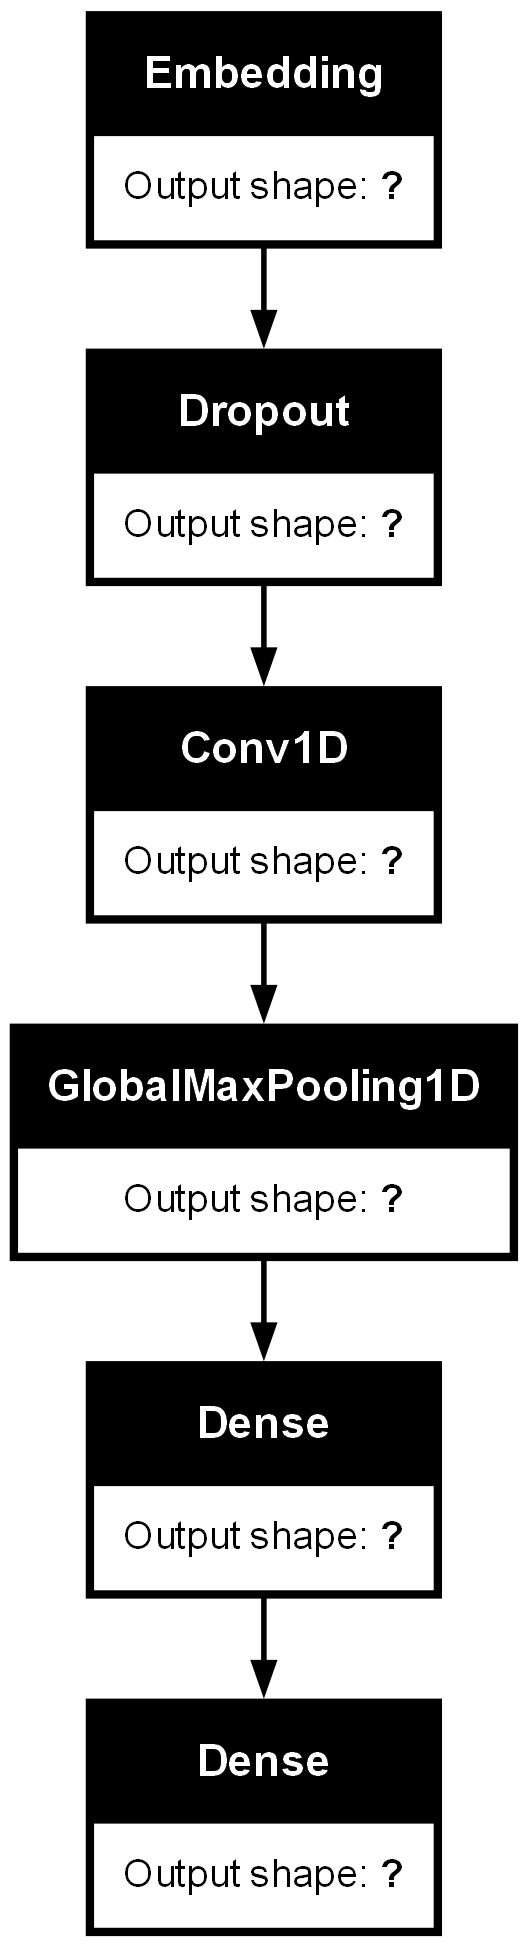

In [19]:
K.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Натренируем LSTM

In [20]:
# Обучение LSTM на тренировочных данных
history = model.fit(

    # Данные для обучения: признаки (отзывы) и классы (положительные или отрицательные)
    x_train, y_train,

    # Количество выборок, обрабатываемых перед обновлением
    # внутренних параметров модели с помощью обратного распространения.
    # Чем выше размер пакета (batch), тем будет больше требоваться памяти.
    batch_size=256,

    # Эпоха - итерация по всему тренировочному набору данных.
    epochs=3,

    # Модель будет оценивать потери и метрики на этой части
    # тренировочных данных, отделив их от обучающей выборки.
    validation_split=0.2,
    verbose=1
)

Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.5686 - loss: 0.6795 - val_accuracy: 0.7688 - val_loss: 0.5105
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.7991 - loss: 0.4446 - val_accuracy: 0.8474 - val_loss: 0.3505
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8737 - loss: 0.3026 - val_accuracy: 0.8696 - val_loss: 0.3052


## Оценим модель с помощью тестовых данных и просмотрим результаты

In [22]:
from sklearn.metrics import classification_report

# Получение предсказаний модели
predicted_probabilities = model.predict(x_test)
predicted_classes = (predicted_probabilities > 0.5).astype('int32')

# Вывод отчета классификации
print(classification_report(y_test, predicted_classes, target_names=class_names))


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

  Негативный       0.85      0.90      0.87     12500
  Позитивный       0.89      0.84      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


## Просмотрим несколько неверных прогнозов

Давайте взглянем на некоторые из неправильно классифицированных обзоров. Для удобства чтения мы уберем отступы.

In [23]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped != y_test)[0]

# Мы выбираем первые 10 неправильно классифицированных отзывов
for j, incorrect in enumerate(incorrect[0:20]):
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])

    print("Неправильно классифицированный тестовый отзыв [" + str(j + 1) + "]")
    print("Тестовый отзыв #" + str(incorrect) + ": Предсказано [" + predicted + "] Фактически [" + actual + "]")
    print("Текст тестового отзыва: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Неправильно классифицированный тестовый отзыв [1]
Тестовый отзыв #2: Предсказано [Негативный] Фактически [Позитивный]
Текст тестового отзыва: at a time when motion picture animation of all sorts was in its <UNKNOWN> br br the political <UNKNOWN> of the russian revolution caused <UNKNOWN> to move to paris where one of his first productions <UNKNOWN> was a dark political satire <UNKNOWN> known as <UNKNOWN> or the <UNKNOWN> who wanted a king a strain of black comedy can be found in almost all of films but here it is very dark indeed aimed more at grown ups who can appreciate the satirical aspects than children who would most likely find the climax <UNKNOWN> i'm middle aged and found it pretty <UNKNOWN> myself and indeed <UNKNOWN> of the film intended for english speaking viewers of the 1920s were given title cards filled with <UNKNOWN> and <UNKNOWN> in order to help <UNKNOWN> the sharp <UNKNOWN> of the finale br br our tale is set in a swamp the <UNKNOWN> <UNKNOWN> where the citizens are 

## Сопоставим свой собственный отзыв с обученной моделью

Это интересный способ проверить возможности обученной модели.
Вы увидите исходный прогноз из модели - в основном значение от 0 до 1.

In [28]:
# Напишем ваш отзыв
review = "This movie was an absolute disaster. The plot was nonsensical, the acting was atrocious, and the directing was terrible. I couldn't stand watching it for more than a few minutes. The dialogue was cringe-worthy, filled with cliches and poorly executed lines. The characters were uninteresting and lacked any depth. The cinematography was amateurish, with shaky camera work and poorly framed shots. The overall experience was incredibly disappointing and I regret wasting my time and money on this garbage. I strongly advise anyone to stay away from this film."

tmp = []
for word in review.lower().split(" "):
    if word in word_index:
        tmp.append(word_index[word])
    else:
        tmp.append(word_index['<UNKNOWN>'])  # Заменить нераспознанные слова на специальный токен <UNK>

tmp_padded = sequence.pad_sequences([tmp], maxlen=review_length)

# Выполнение обработанного отзыва на обученной модели
rawprediction = model.predict(np.array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Тестирование модели и вывод результата
print("Отзыв: " + review)
print("Предсказание (сырые данные): " + str(rawprediction))
print("Предсказанный класс: " + class_names[prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Отзыв: This movie was an absolute disaster. The plot was nonsensical, the acting was atrocious, and the directing was terrible. I couldn't stand watching it for more than a few minutes. The dialogue was cringe-worthy, filled with cliches and poorly executed lines. The characters were uninteresting and lacked any depth. The cinematography was amateurish, with shaky camera work and poorly framed shots. The overall experience was incredibly disappointing and I regret wasting my time and money on this garbage. I strongly advise anyone to stay away from this film.
Предсказание (сырые данные): 0.009271271
Предсказанный класс: Негативный
